In [1]:
import cv2
import os
import numpy as np
from FlagRep0 import truncate_svd, chordal_distance
from FlagRep import FlagRep

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import tqdm
from skimage.transform import rescale

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

import seaborn as sns

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values):
    accuracies = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
        
        # Fit the model using the training distance matrix and labels
        knn.fit(distance_matrix_train, y_train)
        
        # Predict using the test distance matrix
        y_pred = knn.predict(distance_matrix_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"k={k}, Accuracy: {accuracy:.4f}")
        accuracies.append(accuracy)
    
    return accuracies

def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs

def load_avi_files(directory):
    avi_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.avi'):
            avi_files.append(os.path.join(directory, filename))
    return avi_files

def read_avi_to_numpy(file_path, coarsen = .03):
    cap = cv2.VideoCapture(file_path)
    if not cap.isOpened():
        print(f"Error opening video file: {file_path}")
        return None

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)

    cap.release()

    frame_array = np.array(frames)

    X = rescale(frame_array,(1,coarsen,coarsen))
    

    # Convert list of frames to a NumPy array
    return X

def concept_plots(file_path, title, coarsen = .03):
    cap = cv2.VideoCapture(file_path)
    if not cap.isOpened():
        print(f"Error opening video file: {file_path}")
        return None

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)

    cap.release()

    frame_array = np.array(frames)

    fig, ax = plt.subplots(1,2)
    ax[0].imshow(frame_array[frame_array.shape[0]//2,:,:], cmap = 'grey')
    ax[1].imshow(rescale(frame_array,(1,coarsen,coarsen))[frame_array.shape[0]//2,:,:], cmap = 'grey')

    ax[0].axis('off')
    ax[1].axis('off')
    plt.tight_layout()

def evaluate_knn(data_train, data_test, y_train, y_test, k_values):
    accuracies = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        
        # Fit the model using the training distance matrix and labels
        knn.fit(data_train, y_train)
        
        # Predict using the test distance matrix
        y_pred = knn.predict(data_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        # print(f"k={k}, Accuracy: {accuracy:.4f}")
        accuracies.append(accuracy)
    return accuracies

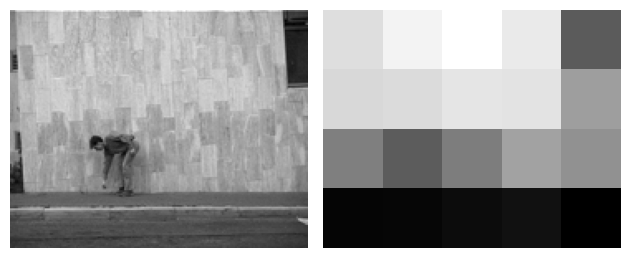

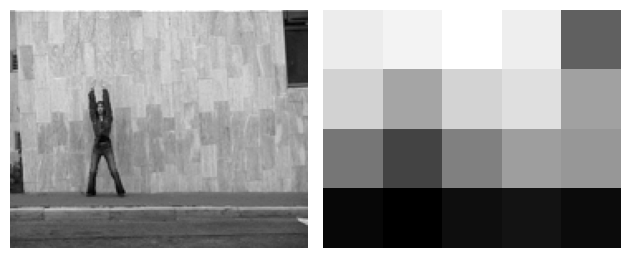

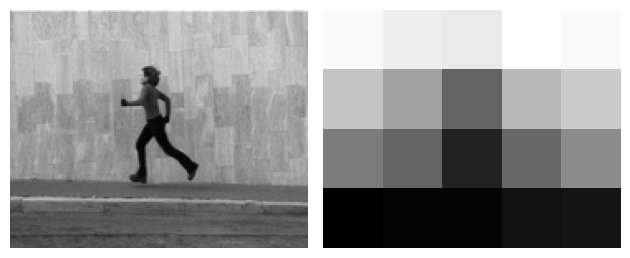

In [2]:


directory = '../data/weizmann/'  # Change to your directory

classes = ['bend', 'jack', 'run']


dataset = []
mod_labels = []
for class_name in classes:
    f_path = os.path.join(directory, class_name)
    avi_files = load_avi_files(f_path)
    data = [read_avi_to_numpy(avi_file, .03) for avi_file in avi_files]
    concept_plots(avi_files[0], class_name)
    dataset += data
    mod_labels += [class_name]*len(data)

    

In [3]:
fewest_frame_count = np.min([len(d) for d in dataset])
_,n_rows, n_cols  = dataset[0].shape

trimmed_dataset = []
for d in dataset:
    n_frames = len(d)
    d_trimmed = d[n_frames//2-fewest_frame_count//2:n_frames//2+fewest_frame_count//2,:,:]
    trimmed_dataset.append(d_trimmed)

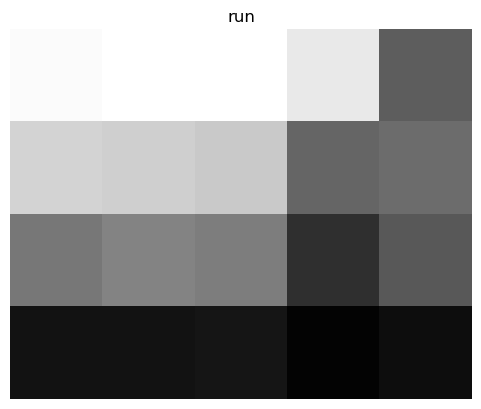

In [4]:
vid_num = 20
array_3d = trimmed_dataset[vid_num]
depth = trimmed_dataset[vid_num].shape[0]
# Set up the figure and axis for plotting
fig, ax = plt.subplots()
cax = ax.imshow(array_3d[0], cmap='grey', interpolation='nearest')

# Set up axis limits (optional, but ensures consistent plot range across frames)
ax.axis('off')

# Initialize function for animation
def init():
    cax.set_data(array_3d[0])
    return [cax]

# Update function for animation
def update(frame):
    cax.set_data(array_3d[frame])
    ax.set_title(f'{mod_labels[vid_num]}')  # Update title with slice number
    return [cax]

# Create the animation, animating over the depth dimension
ani = FuncAnimation(fig, update, frames=depth, init_func=init, blit=True, repeat=True)


HTML(ani.to_jshtml())

<Axes: >

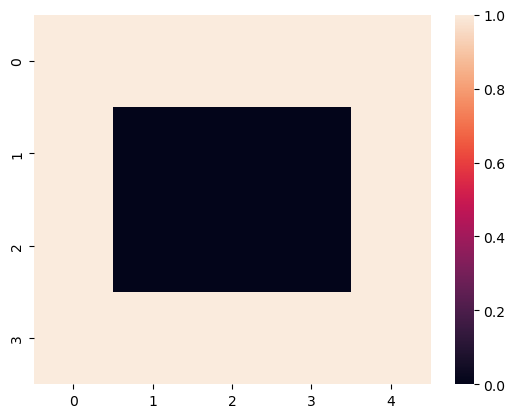

In [5]:
center_row = n_rows//2
center_col = n_cols//2

quarter_row = n_rows//4
quarter_col = n_cols//4

X = []
for d in trimmed_dataset:
    ss1 = d[:,n_rows//4:3*n_rows//4, n_cols//4:3*n_cols//4]
    ss2_mask = np.zeros((n_rows, n_cols), dtype=bool)
    # Set the outer pixels to True
    ss2_mask[:n_rows//4, :] = True  # Top
    ss2_mask[3*n_rows//4:, :] = True  # Bottom
    ss2_mask[:, :n_cols//4] = True  # Left
    ss2_mask[:, 3*n_cols//4+1:] = True  # Right

    
    # plt.axis('off')
    ss2 = d[:,ss2_mask]

    ss1 = ss1.reshape(ss1.shape[0], -1)
    ss2 = ss2.reshape(ss2.shape[0], -1)

    d_flat = np.hstack([ss1,ss2])


    X.append(d_flat)

ss_sizes = [ss1.shape[1], ss2.shape[1]]

sns.heatmap(ss2_mask)

In [6]:
As = [np.arange(len(ss1.T)), np.arange(len(ss1.T)+len(ss2.T))]

In [7]:
Aset = As

In [8]:

flags = {}
flags['FlagRep'] = []
flags['QR'] = []
flags['SVD'] = []

flag_types = {}
flag_types['FlagRep'] = []
flag_types['QR'] = []
flag_types['SVD'] = []

for m in tqdm.tqdm(X):
    my_flag_rep = FlagRep(As, zero_tol = 1e-8)
    frep = my_flag_rep.fit_transform(m)
    frep_ftype = my_flag_rep.flag_type()
    flags['FlagRep'].append(frep)
    flag_types['FlagRep'].append(frep_ftype)

    qr ,_= np.linalg.qr(m)
    flags['QR'].append(qr)
    flag_types['QR'].append(np.arange(1,np.min([m.shape[1], qr.shape[1]])))

    u = truncate_svd(m, eps_rank = eps_rank)
    flags['SVD'].append(u)
    flag_types['SVD'].append(np.arange(1,np.min([m.shape[1], u.shape[1]])))



  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


NameError: name 'eps_rank' is not defined

In [9]:
for method_name in ['FlagRep', 'QR', 'SVD']:

    smallest_dim = np.min([t[-1] for t in flag_types[method_name]])
    flag_types[method_name] = [np.array([t[0],smallest_dim]) for t in flag_types[method_name]]    


In [10]:



n_pts = len(flags['FlagRep'])
dist_mats = {}
for method_name in ['FlagRep', 'QR', 'SVD']:
    #make distance matrices
    dist_mats[method_name] = np.zeros((n_pts,n_pts))
    for i in tqdm.tqdm(range(n_pts)):
        for j in range(i+1,n_pts):
            x = flags[method_name][i]
            y = flags[method_name][j]
            fl_type_x = flag_types[method_name][i]
            fl_type_y = flag_types[method_name][j]
            Bs_x = make_Bs(fl_type_x)
            Bs_y = make_Bs(fl_type_y)
            dist = chordal_distance(x, y, Bs_x, Bs_y)
            dist_mats[method_name][i,j] = dist
            dist_mats[method_name][j,i] = dist
            

100%|██████████| 28/28 [00:00<00:00, 1035.35it/s]


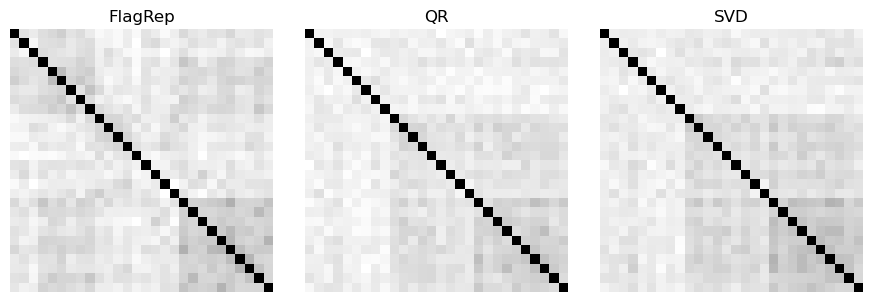

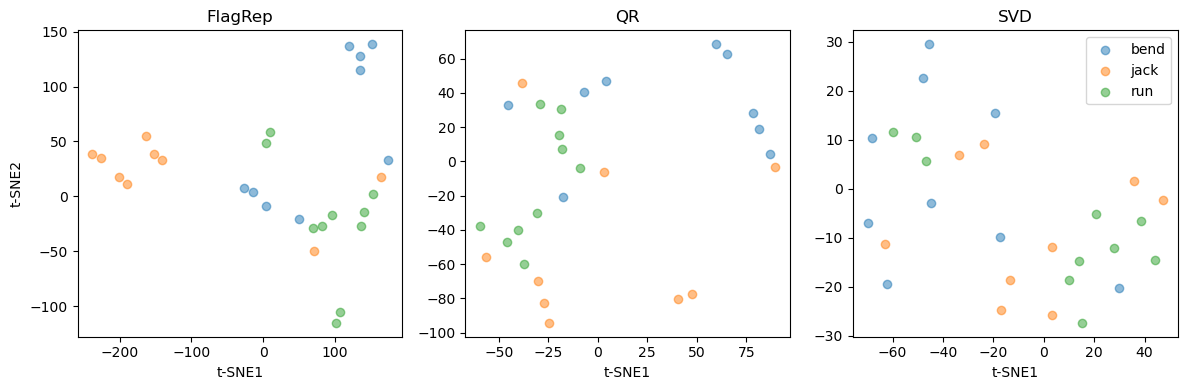

In [11]:
fig,ax = plt.subplots(1,3, figsize = (9,3))

for i, method_name in enumerate(['FlagRep', 'QR', 'SVD']):
    ax[i].set_title(method_name)
    ax[i].imshow(dist_mats[method_name], cmap = 'grey')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('../results/weizmann_dist_mat.pdf', bbox_inches = 'tight')

fig,ax = plt.subplots(1,3, figsize = (12,4))

for i, method_name in enumerate(['FlagRep', 'QR', 'SVD']):
    tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10, perplexity=np.min([len(dist_mats) - 1, 30]))
    vis_data = tsne.fit_transform(dist_mats[method_name])
    for class_name in np.unique(mod_labels):
        idx = np.where(np.array(mod_labels) == str(class_name))
        scatter = ax[i].scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_name)
    ax[i].set_xlabel('t-SNE1')
    ax[i].set_title(method_name)
ax[0].set_ylabel('t-SNE2')
# Create a legend with labels
plt.legend()
plt.tight_layout()
plt.show()

In [12]:


k_values = np.arange(1,20)
n_trials = 100
indices = np.arange(len(mod_labels))

In [13]:
results = pd.DataFrame(columns = ['k','Method Name', 'Accuracy', 'Seed'])

mod_labels = np.array(mod_labels)
for s in range(n_trials):

    # Step 2: Perform train-test split based on labels using the indices
    train_indices, test_indices, _, _ = train_test_split(indices, mod_labels, test_size=0.3, stratify=mod_labels, random_state=s)

    # Step 3: Use these indices to retrieve the corresponding data and labels
    # (This step assumes `data` is an array of the same length as `labels`)
    for method_name in ['FlagRep', 'QR', 'SVD', 'Euclidean']:
        y_train = mod_labels[train_indices]
        y_test = mod_labels[test_indices]
        if method_name == 'Euclidean':
            mod_data = np.vstack([x.flatten() for x in X])
            mod_data_train = mod_data[train_indices, :]
            mod_data_test = mod_data[test_indices,:]
            accs = evaluate_knn(mod_data_train, mod_data_test, y_train, y_test, k_values)
            
        else:
            distance_matrix_train = dist_mats[method_name][train_indices,:][:,train_indices]
            distance_matrix_test = dist_mats[method_name][test_indices,:][:,train_indices]


            # Step 5: Test for different values of k (number of neighbors)

            accs = evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values)

        for k, acc in zip(k_values, accs):
            res = pd.DataFrame(columns = results.columns,
                            data = [[k, method_name, acc, s]])
            results = pd.concat([results,res])

k=1, Accuracy: 0.6667
k=2, Accuracy: 0.6667
k=3, Accuracy: 0.6667
k=4, Accuracy: 0.6667
k=5, Accuracy: 0.6667
k=6, Accuracy: 0.6667
k=7, Accuracy: 0.6667
k=8, Accuracy: 0.7778
k=9, Accuracy: 0.5556
k=10, Accuracy: 0.6667
k=11, Accuracy: 0.5556
k=12, Accuracy: 0.6667
k=13, Accuracy: 0.6667
k=14, Accuracy: 0.6667
k=15, Accuracy: 0.7778
k=16, Accuracy: 0.6667
k=17, Accuracy: 0.5556
k=18, Accuracy: 0.3333
k=19, Accuracy: 0.3333
k=1, Accuracy: 0.5556
k=2, Accuracy: 0.6667
k=3, Accuracy: 0.6667
k=4, Accuracy: 0.6667
k=5, Accuracy: 0.6667
k=6, Accuracy: 0.6667
k=7, Accuracy: 0.6667
k=8, Accuracy: 0.6667
k=9, Accuracy: 0.5556
k=10, Accuracy: 0.6667
k=11, Accuracy: 0.4444
k=12, Accuracy: 0.5556
k=13, Accuracy: 0.5556
k=14, Accuracy: 0.5556
k=15, Accuracy: 0.4444
k=16, Accuracy: 0.4444
k=17, Accuracy: 0.4444
k=18, Accuracy: 0.5556
k=19, Accuracy: 0.3333
k=1, Accuracy: 0.3333
k=2, Accuracy: 0.6667
k=3, Accuracy: 0.6667
k=4, Accuracy: 0.5556
k=5, Accuracy: 0.6667
k=6, Accuracy: 0.5556
k=7, Accurac

/var/folders/5m/bv9phk393431tllslwr8yzyw0000gp/T/ipykernel_57502/3016615956.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,res])


k=1, Accuracy: 0.6667
k=2, Accuracy: 0.7778
k=3, Accuracy: 0.6667
k=4, Accuracy: 0.7778
k=5, Accuracy: 0.6667
k=6, Accuracy: 0.5556
k=7, Accuracy: 0.5556
k=8, Accuracy: 0.5556
k=9, Accuracy: 0.5556
k=10, Accuracy: 0.5556
k=11, Accuracy: 0.5556
k=12, Accuracy: 0.5556
k=13, Accuracy: 0.4444
k=14, Accuracy: 0.4444
k=15, Accuracy: 0.4444
k=16, Accuracy: 0.3333
k=17, Accuracy: 0.5556
k=18, Accuracy: 0.4444
k=19, Accuracy: 0.3333
k=1, Accuracy: 0.5556
k=2, Accuracy: 0.7778
k=3, Accuracy: 0.5556
k=4, Accuracy: 0.4444
k=5, Accuracy: 0.6667
k=6, Accuracy: 0.6667
k=7, Accuracy: 0.5556
k=8, Accuracy: 0.6667
k=9, Accuracy: 0.4444
k=10, Accuracy: 0.6667
k=11, Accuracy: 0.4444
k=12, Accuracy: 0.5556
k=13, Accuracy: 0.4444
k=14, Accuracy: 0.3333
k=15, Accuracy: 0.3333
k=16, Accuracy: 0.3333
k=17, Accuracy: 0.4444
k=18, Accuracy: 0.4444
k=19, Accuracy: 0.3333
k=1, Accuracy: 0.8889
k=2, Accuracy: 1.0000
k=3, Accuracy: 0.8889
k=4, Accuracy: 0.8889
k=5, Accuracy: 0.7778
k=6, Accuracy: 0.7778
k=7, Accurac

([<matplotlib.axis.XTick at 0x29bbd36d0>,
 [Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18')])

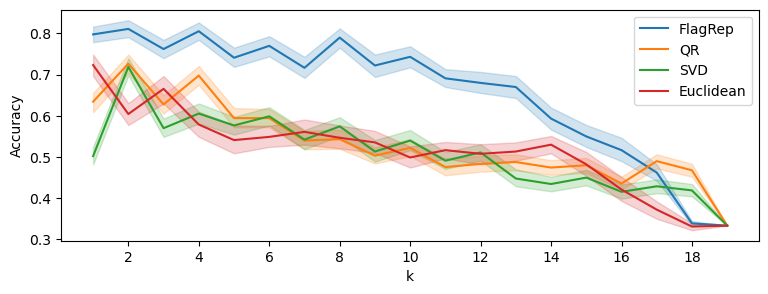

In [14]:
plt.figure(figsize = (9,3))
sns.lineplot(data = results, x = 'k', y = 'Accuracy', hue = 'Method Name')
plt.legend(loc='upper right')
plt.xticks(np.arange(2,k_values[-1]+1,2))
# plt.savefig('../results/weizmann_clustering.pdf', bbox_inches = 'tight')